## Single polygon feature alpha mask and crop example

In [1]:
from skimage import draw, io, util
import numpy as np
import json

### Function for creating a pixel mask

Grabbed this function from:
https://github.com/scikit-image/scikit-image/issues/1103#issuecomment-52378754

In the final script (outside this notebook) I changed the function so it would return an 8-bit unsigned integer array instead of boolean, with 255 (visible alpha) inside of polygon, and 0 (invisible alpha) outside.

In [2]:
def poly2mask(vertex_row_coords, vertex_col_coords, shape):
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=np.bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask

In [3]:
with open('export-2020-04-17T19_22_10.412Z.json','r') as f:
    annotations = json.load(f)

### Annotations list of dictionaries

- `annotations` is a list with annotated image file per entry
- each image file has its own dictionary that stores the file name, the annotation geometry, etc

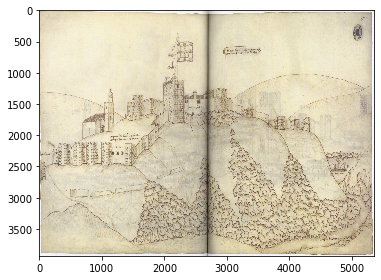

In [4]:
ann1 = annotations[1]
file1 = ann1['External ID']
img1 = io.imread(file1)
io.imshow(img1)

#### shape = (height, width, 3) for 3-channel r,g,b image

In [5]:
img1.shape

(3931, 5363, 3)

### Gather only data relevant for this particular process

- I only want to gather labels that are defined by a polygon region (not pixel-based)
- there's a lot of extra metadata in the object dictionary that I want to ignore for now

In [6]:
objects1 = ann1['Label']['objects']
poly_objects1 = []
for ob in objects1:
    if 'polygon' in ob:
        poly_x = np.array([dd['x'] for dd in ob['polygon']])
        poly_y = np.array([dd['y'] for dd in ob['polygon']])
        poly_objects1.append({'featureId':ob['featureId'],
                              'polygon':ob['polygon'],
                             'poly_x':poly_x, 'poly_y':poly_y})

### Need to be careful about image X Y coordinate directions

The `poly2mask()` function is written in terms of rows and columns of a Numpy array

- y is the height direction on the image, and the rows direction in the array
- x is the width direction on the image, and the columns direction in the array

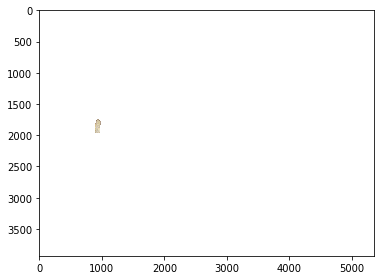

In [7]:
poly1_2 = poly_objects1[2]
ww = poly1_2['poly_x']
hh = poly1_2['poly_y']

mask1_2 = poly2mask(hh, ww, img1.shape[:2])
img1_a = np.zeros((img1.shape[0],img1.shape[1],4),dtype=np.uint8)
img1_a[:,:,:3] = img1
img1_a[:,:,3] = (mask1_2*255).astype('uint8')
io.imshow(img1_a)

### Slice into the Numpy array to do the crop

We build slice objects so we can use variables and calculations as bounds for slicing into the image array

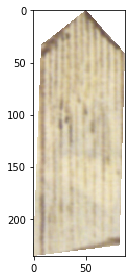

In [8]:
crop_w = slice(ww.min().round().astype('int'), ww.max().round().astype('int'))
crop_h = slice(hh.min().round().astype('int'), hh.max().round().astype('int'))

img1_a_cropped = img1_a[crop_h,crop_w,:]
io.imshow(img1_a_cropped)

### Save the image

Just concatenating the original file name with the feature ID for now and saving as PNG with alpha

In [9]:
io.imsave(file1.replace('.','_') +'_'+ poly1_2['featureId'] +'_test.png', img1_a_cropped)